This notebook applies an inverted Transformer model using PyTorch & Lightning, to get multi-step quantile energy consumption forecasts. 
\
It also performs the necessary data handling & preprocessing steps to get source & target sequences for the Transformer model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import lightning as L
import optuna
import warnings

from lightning.pytorch.callbacks import Callback
from optuna.integration import PyTorchLightningPruningCallback
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, root_mean_squared_log_error as rmsle, mean_pinball_loss as pinball

In [2]:
random_seed = 1923

In [3]:
# Set Torch settings
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')
L.seed_everything(random_seed, workers = True)
warnings.filterwarnings("ignore", ".*does not have many workers.*")

Seed set to 1923


In [4]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [5]:
output_dir = "./OutputData/"

In [6]:
df = pd.read_csv(output_dir + "train_data.csv")
df["time"] = pd.to_datetime(df["time"])

In [7]:
df

,time,consumption_MWh,consumption_lag2,trend,biyearly_sin,biyearly_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
0,2018-01-01 02:00:00,24635.32,27412.81,2,0.002869,0.999996,0.074526,0.997219,0.500000,8.660254e-01
1,2018-01-01 03:00:00,23872.12,26324.39,3,0.004304,0.999991,0.111659,0.993747,0.707107,7.071068e-01
2,2018-01-01 04:00:00,23194.89,24635.32,4,0.005738,0.999984,0.148637,0.988892,0.866025,5.000000e-01
3,2018-01-01 05:00:00,23071.96,23872.12,5,0.007173,0.999974,0.185408,0.982662,0.965926,2.588190e-01
4,2018-01-01 06:00:00,23267.90,23194.89,6,0.008607,0.999963,0.221922,0.975065,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...
52577,2023-12-31 19:00:00,35090.93,34549.42,52579,0.027252,0.999629,0.650811,0.759240,-0.965926,2.588190e-01
52578,2023-12-31 20:00:00,33310.94,36193.59,52580,0.028686,0.999588,0.678669,0.734444,-0.866025,5.000000e-01
52579,2023-12-31 21:00:00,32083.96,35090.93,52581,0.030120,0.999546,0.705584,0.708627,-0.707107,7.071068e-01
52580,2023-12-31 22:00:00,30469.49,33310.94,52582,0.031554,0.999502,0.731517,0.681823,-0.500000,8.660254e-01


## Data prep: Getting input & output sequences

We will create a "shifted dataset" where each row at time T contains the following columns:
- Target value at T (consumption lead T+1),
- Past value at T (consumption lag T-2),
- Time covariates at T.

In [8]:
# Get shifted dataset, drop last row due to unknown target
df_shifted = df.copy()
df_shifted["consumption_MWh"] = df_shifted.consumption_MWh.shift(-1)
df_shifted = df_shifted.dropna()

In [9]:
df_shifted

,time,consumption_MWh,consumption_lag2,trend,biyearly_sin,biyearly_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
0,2018-01-01 02:00:00,23872.12,27412.81,2,0.002869,0.999996,0.074526,0.997219,0.500000,8.660254e-01
1,2018-01-01 03:00:00,23194.89,26324.39,3,0.004304,0.999991,0.111659,0.993747,0.707107,7.071068e-01
2,2018-01-01 04:00:00,23071.96,24635.32,4,0.005738,0.999984,0.148637,0.988892,0.866025,5.000000e-01
3,2018-01-01 05:00:00,23267.90,23872.12,5,0.007173,0.999974,0.185408,0.982662,0.965926,2.588190e-01
4,2018-01-01 06:00:00,23875.44,23194.89,6,0.008607,0.999963,0.221922,0.975065,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...
52576,2023-12-31 18:00:00,35090.93,32670.06,52578,0.025818,0.999667,0.622047,0.782980,-1.000000,-1.703645e-12
52577,2023-12-31 19:00:00,33310.94,34549.42,52579,0.027252,0.999629,0.650811,0.759240,-0.965926,2.588190e-01
52578,2023-12-31 20:00:00,32083.96,36193.59,52580,0.028686,0.999588,0.678669,0.734444,-0.866025,5.000000e-01
52579,2023-12-31 21:00:00,30469.49,35090.93,52581,0.030120,0.999546,0.705584,0.708627,-0.707107,7.071068e-01


Every source sequence will be the last 72 hours before 16:00, and every target sequence will be the next 32 hours after 16:00.

In [10]:
# Set fixed parameters
n_steps = len(df_shifted) 
source_length = 72 # T-L to T hours
source_dims = 8 # Number of covariates
target_length = 32 # We are only interested in predicting T+8 to 32, but we'll make this a model parameter
horizon_start = 0 # Output step to start loss calculation from
quantiles = [0.025, 0.5, 0.975] # Quantiles to predict

In [11]:
# Find the index of the first 16:00 row in the data, where the index is bigger than source_length - 1. This will be the first T.
first_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index >= source_length - 1)].index.values[0]

In [12]:
first_t 

86

In [13]:
# Find the index of the last 16:00 row in the data, with 32 time steps after it. This will be the last T.
last_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index + target_length - 1 <= df.index.values[-1])].index.values[-2]

In [14]:
last_t 

52526

Each source sequence will contain the following:
- Consumption lag 2 at [T - source_length, T] (past targets),
- Time covariates at [T - source_length, T] (past covariates).

In [15]:
# One source sequence
source_seq = pd.concat([
    df_shifted.iloc[(first_t - source_length):first_t, 0], # Time
    df_shifted.iloc[(first_t - source_length):first_t, 2], # Past target
    df_shifted.iloc[(first_t - source_length):(first_t), 3:] # Past covariates
], axis = 1)

Each output sequence will contain the following:
- Consumption at [T+1, T + output_length] (future targets),
- Time covariates at [T+1, T + output_length] (future known covariates)

In [16]:
# One output sequence
target_seq = pd.concat([
    df_shifted.iloc[first_t:(first_t + target_length), 0], # Time 
    df_shifted.iloc[first_t:(first_t + target_length), 1], # Future target
    df_shifted.iloc[first_t:(first_t + target_length), 3:] # Future known covariates
], axis = 1)

In [17]:
source_seq.iloc[-5:]

,time,consumption_lag2,trend,biyearly_sin,biyearly_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
81,2018-01-04 11:00:00,39641.36,83,0.118784,0.992920,0.045888,-0.998947,2.588190e-01,-0.965926
82,2018-01-04 12:00:00,40593.83,84,0.120208,0.992749,0.008607,-0.999963,8.572528e-16,-1.000000
83,2018-01-04 13:00:00,40955.07,85,0.121632,0.992575,-0.028686,-0.999588,-2.588190e-01,-0.965926
84,2018-01-04 14:00:00,39505.55,86,0.123056,0.992400,-0.065940,-0.997824,-5.000000e-01,-0.866025
85,2018-01-04 15:00:00,39635.29,87,0.124479,0.992222,-0.103102,-0.994671,-7.071068e-01,-0.707107


In [18]:
target_seq[:5]

,time,consumption_MWh,trend,biyearly_sin,biyearly_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
86,2018-01-04 16:00:00,40487.65,88,0.125902,0.992043,-0.140120,-0.990135,-0.866025,-5.000000e-01
87,2018-01-04 17:00:00,39936.25,89,0.127325,0.991861,-0.176944,-0.984221,-0.965926,-2.588190e-01
88,2018-01-04 18:00:00,38772.68,90,0.128748,0.991677,-0.213521,-0.976938,-1.000000,8.578717e-16
89,2018-01-04 19:00:00,38113.86,91,0.130171,0.991492,-0.249801,-0.968297,-0.965926,2.588190e-01
90,2018-01-04 20:00:00,36758.94,92,0.131593,0.991304,-0.285734,-0.958309,-0.866025,5.000000e-01


In [19]:
df_shifted.iloc[81:90]

,time,consumption_MWh,consumption_lag2,trend,biyearly_sin,biyearly_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
81,2018-01-04 11:00:00,39505.55,39641.36,83,0.118784,0.992920,0.045888,-0.998947,2.588190e-01,-9.659258e-01
82,2018-01-04 12:00:00,39635.29,40593.83,84,0.120208,0.992749,0.008607,-0.999963,8.572528e-16,-1.000000e+00
83,2018-01-04 13:00:00,39952.75,40955.07,85,0.121632,0.992575,-0.028686,-0.999588,-2.588190e-01,-9.659258e-01
84,2018-01-04 14:00:00,39649.45,39505.55,86,0.123056,0.992400,-0.065940,-0.997824,-5.000000e-01,-8.660254e-01
85,2018-01-04 15:00:00,40063.17,39635.29,87,0.124479,0.992222,-0.103102,-0.994671,-7.071068e-01,-7.071068e-01
86,2018-01-04 16:00:00,40487.65,39952.75,88,0.125902,0.992043,-0.140120,-0.990135,-8.660254e-01,-5.000000e-01
87,2018-01-04 17:00:00,39936.25,39649.45,89,0.127325,0.991861,-0.176944,-0.984221,-9.659258e-01,-2.588190e-01
88,2018-01-04 18:00:00,38772.68,40063.17,90,0.128748,0.991677,-0.213521,-0.976938,-1.000000e+00,8.578717e-16
89,2018-01-04 19:00:00,38113.86,40487.65,91,0.130171,0.991492,-0.249801,-0.968297,-9.659258e-01,2.588190e-01


In the source sequence, we pair every past target value at T with the past covariates at T.
\
In the output sequence, we pair every future target value at T+1 with the future covariates at T+1.
\
This is more straightforward than the LSTM sequencing in notebook 3.1, because we will make our predictions in one go, and don't need to combine predictions at T+1 with future covariates at T+2 to get the input sequence for T+1. 
\
We will simply initialize the future targets from T+1 onwards as a linear extrapolation of the past targets from T - source_length to T. We'll do this in training as well as validation & prediction. 
\
The idea is that the model should learn to "enrich" a simple linear extrapolation given additional future known covariates.

In [20]:
n_sequences = (last_t - first_t) // 24 + 1 # Number of 16:00 rows followed by a sufficient length source / target sequence
print("Number of possible sequences: " + f"{n_sequences}")

Number of possible sequences: 2186


In [21]:
# Get all sequences
for t in range(first_t, last_t + 1, 24):

    # Get source sequence
    new_source = pd.concat([
        df_shifted.iloc[(t - source_length):t, 0], # Time
        df_shifted.iloc[(t - source_length):t, 2], # Past target
        df_shifted.iloc[(t - source_length):t, 3:] # Past covariates
        ], axis = 1)
    new_source = new_source.set_index("time")

    # Get target sequence
    new_target = pd.concat([
        df_shifted.iloc[t:(t + target_length), 0], # Time 
        df_shifted.iloc[t:(t + target_length), 1], # Future target
        df_shifted.iloc[t:(t + target_length), 3:] # Future known covariates
        ], axis = 1)
    new_target = new_target.set_index("time")

    if t == first_t:

        # Initialize lists of sequences
        source_sequences = [new_source]
        target_sequences = [new_target]
        
    else:
        # Concatenate to arrays of sequences
        source_sequences.append(new_source)
        target_sequences.append(new_target)


In [22]:
len(source_sequences)

2186

In [23]:
len(target_sequences)

2186

## Preprocessing: Custom scaler, Torch datasets & dataloaders

In [24]:
# Get indices for train - val - test split
sixty_percent = int(len(source_sequences) * 0.6)
twenty_percent = int(len(target_sequences) * 0.2)
train_end = sixty_percent
val_end = sixty_percent + twenty_percent

We'll keep batch sizes constant to match the evaluation scheme with the stateful LSTM in notebook 3.1, though there should be no need with this model. 
\
We'll divide the lengths of each data fold with the batch size, drop the remainder from the start of the training folds & the end of the val. & test folds.

In [25]:
# Perform train - val - test split
batch_size = 64

# Training data at validation step
tr_source, tr_target = source_sequences[0:train_end], target_sequences[0:train_end]
remainder = len(tr_source) % batch_size
tr_source, tr_target = tr_source[remainder:], tr_target[remainder:]

# Training data at testing step
train_source, train_target = source_sequences[0:val_end], target_sequences[0:val_end]
remainder = len(train_source) % batch_size
train_source, train_target = train_source[remainder:], train_target[remainder:]

# Validation data
val_source, val_target = source_sequences[train_end:val_end], target_sequences[train_end:val_end]
remainder = len(val_source) % batch_size
val_source, val_target = val_source[:-remainder], val_target[:-remainder]

# Testing data
test_source, test_target = source_sequences[val_end:], target_sequences[val_end:]
remainder = len(test_source) % batch_size
test_source, test_target = test_source[:-remainder], test_target[:-remainder]

In [26]:
test_source[0]

,consumption_lag2,trend,biyearly_sin,biyearly_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos
time,,,,,,,,
2022-10-15 16:00:00,36626.13,41968,-0.491279,-0.871002,0.707614,0.706599,-8.660254e-01,-5.000000e-01
2022-10-15 17:00:00,35781.60,41969,-0.492528,-0.870297,0.733470,0.679722,-9.659258e-01,-2.588190e-01
2022-10-15 18:00:00,35326.54,41970,-0.493776,-0.869589,0.758306,0.651899,-1.000000e+00,-8.137897e-13
2022-10-15 19:00:00,35455.95,41971,-0.495022,-0.868880,0.782087,0.623169,-9.659258e-01,2.588190e-01
2022-10-15 20:00:00,36296.82,41972,-0.496268,-0.868169,0.804780,0.593573,-8.660254e-01,5.000000e-01
...,...,...,...,...,...,...,...,...
2022-10-18 11:00:00,38067.75,42035,-0.572597,-0.819837,-0.142960,-0.989728,2.588190e-01,-9.659258e-01
2022-10-18 12:00:00,38820.67,42036,-0.573772,-0.819015,-0.179767,-0.983709,-9.325514e-14,-1.000000e+00
2022-10-18 13:00:00,39206.44,42037,-0.574947,-0.818191,-0.216323,-0.976322,-2.588190e-01,-9.659258e-01


In [27]:
# First prediction point in testing data
test_target[0].index[0]

Timestamp('2022-10-18 16:00:00')

We have to scale the past consumption values in the source sequences, and covariates in both source & target sequences. 
\
We also need to scale the real target consumption values because they are used in the loss calculation, even if not passed as input to the model.
\
We also need the ability to backtransform the network's final predictions accordingly.

In [28]:
# Define scaling class for sequence data
class sequence_scaler:
    """
    Takes in lists of dataframes where each dataframe is a source or target sequence.

    Returns scaled 3D numpy arrays of shape (observations, timesteps, features).
    Can also backtransform scaled predictions.
    """

    def __init__(self, feature_range = (-1, 1)):
        self.lower = feature_range[0]
        self.upper = feature_range[1]

    def fit(self, source_df, target_df):

        # Get source & target sequences as 3D arrays
        # The time index will be skipped, yielding shape (N, seq_length, seq_dims)
        source = np.stack(source_df, axis = 0)
        target = np.stack(target_df, axis = 0)

        # Get number of dimensions
        self.num_dimensions = source.shape[2]
        
        # Extract & save minimum, maximum for each dimension
        dimensions_mini = []
        dimensions_maxi = []
        for dimension in range(0, self.num_dimensions):
            min = np.min([
                np.min(source[:, :, dimension]),
                np.min(target[:, :, dimension])
            ])
            dimensions_mini.append(min)

            max = np.max([
                np.max(source[:, :, dimension]),
                np.max(target[:, :, dimension])
            ])
            dimensions_maxi.append(max)

        self.dimensions_mini = dimensions_mini
        self.dimensions_maxi = dimensions_maxi

    def transform(self, scale_df):

        # Get sequence as 3D arrays
        scale_array = np.stack(scale_df, axis = 0)

        # Initialize list of scaled dimensions
        scaled_dimensions = []

        # Scale each dimension & append to list
        for dimension in range(0, self.num_dimensions):
            values = scale_array[:, :, dimension]
            min = self.dimensions_mini[dimension]
            max = self.dimensions_maxi[dimension]
            std = (values - min) / (max - min)
            scaled = std * (self.upper - self.lower) + self.lower
            scaled_dimensions.append(scaled)

        # Stack over 3rd axis & return
        return np.stack(scaled_dimensions, axis = 2)

    def backtransform_preds(self, preds_array, fitted_preds_dim = 0):

        # Get n. of predicted quantiles to backtransform
        n_quantiles = preds_array.shape[-1]

        # Get the fitted mini & maxi for predictions
        min = self.dimensions_mini[fitted_preds_dim] 
        max = self.dimensions_maxi[fitted_preds_dim]

        # Initialize list of backtransformed quantiles
        backtrafo_quantiles = []

        # Backtransform each quantile & append to list
        for quantile in range(0, n_quantiles):
            scaled = preds_array[:, :, quantile]
            std = (scaled - self.lower) / (self.upper - self.lower)
            values = std * (max - min) + min
            backtrafo_quantiles.append(values)
            
        # Stack over 3rd axis & return
        return np.stack(backtrafo_quantiles, axis = 2)

We can use one Torch dataset class both for training & validation (known future targets part of passed target sequences), and for prediction (no known future targets in the target sequences).
\
In the former case, both the source & target sequence need to have D feature dimensions (including targets). In the latter case, the target sequence needs to have D-1 feature dimensions, without targets.

In [29]:
# Define Torch dataset class
class SequenceDataset(torch.utils.data.Dataset):
    """
    Simply takes in the source & target sequences as 3D arrays and returns them as Torch tensors.
    """

    # Store preprocessed source & target sequences
    def __init__(self, source_seq, target_seq): 
        self.source_seq = torch.tensor(source_seq, dtype = torch.float32) # Store source sequences
        self.target_seq = torch.tensor(target_seq, dtype = torch.float32) # Store target sequences
  
    # Return data length  
    def __len__(self):
        return len(self.source_seq) 
  
    # Return a pair of source & target sequences
    def __getitem__(self, idx):
        return self.source_seq[idx], self.target_seq[idx]

In [30]:
# Scale validation data & create Torch datasets
scaler_val = sequence_scaler()
_ = scaler_val.fit(tr_source, tr_target)
tr_data = SequenceDataset(scaler_val.transform(tr_source), scaler_val.transform(tr_target))
val_data = SequenceDataset(scaler_val.transform(val_source), scaler_val.transform(val_target))

# Scale testing data & create Torch datasets. Index out the target values for the testing target sequences
scaler_test = sequence_scaler()
_ = scaler_test.fit(train_source, train_target)
train_data = SequenceDataset(scaler_test.transform(train_source), scaler_test.transform(train_target))
test_data = SequenceDataset(scaler_test.transform(test_source), scaler_test.transform(test_target)[:, :, 1:])

In [31]:
# Create Torch dataloaders
num_workers = 0
shuffle = False

# Training data at validation step
tr_loader = torch.utils.data.DataLoader(
    tr_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Training data at testing step
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Validation & testing data
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

## Model definition

In [32]:
# Define QuantileLoss, because pytorch_forecasting installation raises issues with Python 3.12
class QuantileLoss:
    """
    Takes in targets of shape (...),
    predictions of shape (..., n_quantiles),
    quantiles list.
    
    Returns unreduced quantile loss tensor of shape (..., n_quantiles),
    where each value is quantile loss * 2 (equal to the MAE for q = 0.5).
    
    Implemented from pytorch_forecasting.metrics.quantile.QuantileLoss.
    """

    def __init__(self, quantiles):
        self.quantiles = quantiles

    def loss(self, pred, target):
        
        quantile_losses = []
        for i, q in enumerate(self.quantiles):
            error = target - pred[..., i]
            quantile_error = torch.max(
                (q - 1) * error,
                q * error
            ).unsqueeze(-1)
            quantile_losses.append(quantile_error)

        quantile_losses = torch.cat(quantile_losses, dim = 2)
        return quantile_losses

In [33]:
# Define model class
class LITransformer(L.LightningModule):
    """
    Transformer architecture which takes in inverted sequences of shape (batch_size, features, timesteps) as input.
    
    In both training & inference, the past target values from the source sequence are linearly extrapolated to initialize 
    the target values in the target sequence.
    
    The source sequence consists of past target & covariate values, and is fed to the encoder.
    The target sequence consists of the linear trend prediction & covariate values, and is fed to the decoder.
    No causal masking is applied, as true target values are not fed to the model.
    
    The model outputs quantile predictions.
    """

    # Initialize model
    def __init__(self, hyperparams_dict):
        
        # Delegate function to parent class
        super().__init__() 
        
        # Save external hyperparameters so they are available when loading saved models
        self.save_hyperparameters(logger = False) 

        # Define hyperparameters
        self.source_length = hyperparams_dict["source_length"] # Length of source sequence, L
        self.target_length = hyperparams_dict["target_length"] # Length of target sequence, H
        self.horizon_start = hyperparams_dict["horizon_start"] # Start of the forecast horizon relevant for loss computing
        self.quantiles = hyperparams_dict["quantiles"] # Provide as list of floats: [0.025, 0.5, 0.975]
        self.d_model = hyperparams_dict["d_model"] # Dimensionality of attention inputs, d
        self.n_heads = hyperparams_dict["n_heads"] # N. of attention heads per multiattention block
        self.n_encoders = hyperparams_dict["n_encoders"] # N. of encoder blocks
        self.n_decoders = hyperparams_dict["n_decoders"] # N. of decoder blocks
        self.d_feedforward = hyperparams_dict["d_feedforward"] # Dimensionality of feedforward networks
        self.activation = hyperparams_dict["activation"] # Activation function for transformer FFNs
        self.learning_rate = hyperparams_dict["learning_rate"]
        self.lr_decay = hyperparams_dict["lr_decay"]
        self.dropout_rate = hyperparams_dict["dropout_rate"]

        # Define loss function: Quantile loss
        self.loss = QuantileLoss(quantiles = self.quantiles)
        self.n_quantiles = len(self.quantiles) # Number of quantiles, Q

        # Define architecture components

        # Source projection, input shape (N, D, L), output shape (N, D, d)
        self.source_project = torch.nn.Linear(
            in_features = self.source_length,
            out_features = self.d_model
        )

        # Target projection, input shape (N, D, H), output shape (N, D, d)
        self.target_project = torch.nn.Linear(
            in_features = self.target_length,
            out_features = self.d_model
        )

        # Dropout layer for projections
        self.dropout = torch.nn.Dropout(p = self.dropout_rate)

        # Transformer, input shapes (N, D, d), output shape (N, D, d)
        self.transformer = torch.nn.Transformer(
            d_model = self.d_model,
            nhead = self.n_heads,
            num_encoder_layers = self.n_encoders,
            num_decoder_layers = self.n_decoders,
            dim_feedforward = self.d_feedforward,
            dropout = self.dropout_rate,
            activation = self.activation,
            batch_first = True
        )
        
        # Output layer, input shape (N, D, d), output shape (N, D, H * Q)
        # The output is flattened across timesteps & quantiles, needs to be 
        # indexed & reshaped into shape (N, H, Q) 
        self.output_layer = torch.nn.Linear(
            in_features = self.d_model,
            out_features = self.target_length * self.n_quantiles
        )

    # Define linear trend extrapolation method
    # Input: Past targets(N, L) 
    # Output: Linearly extrapolated future targets(N, H)
    def linear_trend(self, past_target):

        # Get batch size
        batch_size = past_target.shape[0]

        # Get timestep index vectors
        past_idx = torch.arange(0, self.source_length).float()
        future_idx = torch.arange(
            self.source_length, 
            (self.source_length + self.target_length)).float()

        # Get vectors & matrices for linear extrapolation
        ones = torch.ones(self.source_length)
        x = torch.stack((past_idx, ones), 1).to("cpu")
        x_t = torch.transpose(x, 0, 1).to("cpu")
        y = past_target.unsqueeze(-1).to("cpu") 
        
        # Estimate linear extrapolation parameters for each batch
        params = torch.matmul(
            torch.matmul(x_t, y).squeeze(-1), torch.linalg.inv(torch.matmul(x_t, x))
        )
        slopes = params[:, 0]
        constants = params[:, 1]

        # Extrapolate trend to future for each batch
        future_target = future_idx.repeat(batch_size, 1) * slopes.unsqueeze(-1) + constants.unsqueeze(-1)
        return future_target.to(self.device)

    # Define forward propagation
    def forward(self, source_seq, target_seq):

        # Project source & target sequences
        # Inputs: Inverted source(N, D, L) and target(N, D, H) sequences
        source = self.dropout(self.source_project(source_seq))
        target = self.dropout(self.target_project(target_seq))

        # Pass source & target sequences to transformer
        # Causal masking is disabled for the target sequence, as the passed values are predictions
        # Inputs: Projected source and target sequences, (N, D, d)
        transformer_output = self.transformer(
            source, target,
            src_is_causal = False,
            tgt_is_causal = False
        )

        # Pass transformer outputs to output layer, with residual connection to pre-transformer target sequence
        # Input: Transformer output(N, D, d)
        output = self.output_layer(target + transformer_output)

        # Output: Flattened quantile predictions(N, D, H * Q)
        return output

    # Define training step
    # Assumes both source & target sequences are passed to SequenceDataset with D dimensions, target values included
    def training_step(self, batch, batch_idx):

        # Get raw source & target sequences from dataloader
        # Shapes (N, L, D), (N, H, D)
        source_seq, target_seq = batch
        
        # Cast aside real future targets for loss calculation
        real_future_target = target_seq[:, :, 0] # Shape (N, H)
        target_seq = target_seq[:, :, 1:] # Shape (N, H, D-1)

        # Use past targets to extrapolate linear trend to future,
        # concatenate the future trend component with future covariates
        past_target = source_seq[:, :, 0] # Shape (N, L)
        future_target = self.linear_trend(past_target) # Shape (N, H)
        target_seq = torch.cat((
                future_target.unsqueeze(-1),
                target_seq, 
            ), dim = 2) # Shape (N, H, D)

        # Invert the sequences  
        # BRAVO NOLAN
        source_seq = torch.permute(source_seq, (0, 2, 1)) # Shape (N, D, L)
        target_seq = torch.permute(target_seq, (0, 2, 1)) # Shape (N, D, H)

        # Forward propagation
        output = self.forward(source_seq, target_seq) # Shape (N, D, H * Q)

        # Get quantile predictions from output tensor
        preds = output.view(output.shape[0], output.shape[1], self.target_length, self.n_quantiles) # Shape (N, D, H, Q)
        preds = preds[:, 0, :, :] # Shape (N, H, Q)

        # Calculate loss, starting from the chosen future time step  
        loss = self.loss.loss(
            preds[:, self.horizon_start:, :], 
            real_future_target[:, self.horizon_start:]
        ) # Shape (N, H - horizon_start, Q)

        # Reduce the quantile loss
        loss_reduced = loss.mean(dim = 2) # Average over quantiles. Shape (N, H - horizon_start)
        loss_reduced = loss_reduced.sum(dim = 1) # Sum over forecast steps. Shape (N)
        loss_reduced = loss_reduced.mean() # Average over batches. Yields scalar loss for backpropagation.

        # Log the train loss
        self.log("train_loss", loss_reduced, on_step = True, on_epoch = True, prog_bar = True, logger = False)

        return loss_reduced
    
    # Define validation_step
    # Assumes both source & target sequences are passed to SequenceDataset with D dimensions, target values included
    def validation_step(self, batch, batch_idx):

        # Get raw source & target sequences from dataloader
        # Shapes (N, L, D), (N, H, D)
        source_seq, target_seq = batch
        
        # Cast aside real future targets for loss calculation
        real_future_target = target_seq[:, :, 0] # Shape (N, H)
        target_seq = target_seq[:, :, 1:] # Shape (N, H, D-1)

        # Use past targets to extrapolate linear trend to future,
        # concatenate the future trend component with future covariates
        past_target = source_seq[:, :, 0] # Shape (N, L)
        future_target = self.linear_trend(past_target) # Shape (N, H)
        target_seq = torch.cat((
                future_target.unsqueeze(-1),
                target_seq, 
            ), dim = 2) # Shape (N, H, D)

        # Invert the sequences  
        source_seq = torch.permute(source_seq, (0, 2, 1)) # Shape (N, D, L)
        target_seq = torch.permute(target_seq, (0, 2, 1)) # Shape (N, D, H)

        # Forward propagation
        output = self.forward(source_seq, target_seq) # Shape (N, D, H * Q)

        # Get quantile predictions from output tensor
        preds = output.view(output.shape[0], output.shape[1], self.target_length, self.n_quantiles) # Shape (N, D, H, Q)
        preds = preds[:, 0, :, :] # Shape (N, H, Q)

        # Calculate loss, starting from the chosen future time step  
        loss = self.loss.loss(
            preds[:, self.horizon_start:, :], 
            real_future_target[:, self.horizon_start:]
        ) # Shape (N, H - horizon_start, Q)

        # Reduce the quantile loss
        loss_reduced = loss.mean(dim = 2) # Average over quantiles. Shape (N, H - horizon_start)
        loss_reduced = loss_reduced.sum(dim = 1) # Sum over forecast steps. Shape (N)
        loss_reduced = loss_reduced.mean() # Average over batches. Yields scalar loss.

        # Log the validation loss
        self.log("val_loss", loss_reduced, on_step = True, on_epoch = True, prog_bar = True, logger = False)

    # Define prediction_step
    # Assumes target sequences are passed to SequenceDataset with D-1 dimensions, target values excluded
    def predict_step(self, batch, batch_idx):

        # Get raw source & target sequences from dataloader
        # Shapes (N, L, D), (N, H, D-1)
        source_seq, target_seq = batch
        
        # Use past targets to extrapolate linear trend to future,
        # concatenate the future trend component with future covariates
        past_target = source_seq[:, :, 0] # Shape (N, L)
        future_target = self.linear_trend(past_target) # Shape (N, H)
        target_seq = torch.cat((
                future_target.unsqueeze(-1),
                target_seq, 
            ), dim = 2) # Shape (N, H, D)

        # Invert the sequences  
        source_seq = torch.permute(source_seq, (0, 2, 1)) # Shape (N, D, L)
        target_seq = torch.permute(target_seq, (0, 2, 1)) # Shape (N, D, H)

        # Forward propagation
        output = self.forward(source_seq, target_seq) # Shape (N, D, H * Q)

        # Get quantile predictions from output tensor
        preds = output.view(output.shape[0], output.shape[1], self.target_length, self.n_quantiles) # Shape (N, D, H, Q)
        preds = preds[:, 0, :, :] # Shape (N, H, Q)
        return preds

    # Define optimizer & learning rate scheduler
    def configure_optimizers(self):

        # Adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        
        # Exponential LR scheduler
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
          optimizer, gamma = self.lr_decay) 
        
        return {
        "optimizer": optimizer,
        "lr_scheduler": {
          "scheduler": lr_scheduler
          }
        }

## Hyperparameter tuning with Optuna

In [34]:
# Define tuning parameters
tol = 0.002 # Change in MAE to avoid early stopping
patience = 5 # N. of rounds with no improvement before early stopping

In [35]:
# Define Optuna objective
def objective_transformer(trial):

    # Define search space
    d_model = 2 ** trial.suggest_int("d_model", 2, 6) # Powers of 2, 4 to 128
    n_heads = 2 ** trial.suggest_int("n_heads", 1, 3) # Powers of 2, 2 to 8
    n_encoders = trial.suggest_int("n_encoders", 1, 3) # 1 to 3
    d_feedforward = 2 ** trial.suggest_int("d_feedforward", 2, 6) # Powers of 2, 4 to 128
    activation = trial.suggest_categorical("activation", ["relu", "gelu"])
    learning_rate = trial.suggest_float("learning_rate", 5e-4, 5e-2) # 0.0005 to 0.05
    lr_decay = trial.suggest_float("lr_decay", 0.9, 1)
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.1)

    # Probably best to match n. of encoder & decoder layers
    n_decoders = n_encoders

    # Create hyperparameters dict
    hyperparameters_dict = {
        "source_length": source_length,
        "target_length": target_length,
        "horizon_start": horizon_start,
        "quantiles": quantiles,
        "d_model": d_model,
        "n_heads": n_heads,
        "n_encoders": n_encoders,
        "n_decoders": n_decoders,
        "d_feedforward": d_feedforward,
        "activation": activation,
        "learning_rate": learning_rate,
        "lr_decay": lr_decay,
        "dropout_rate": dropout_rate
    }

    # Create early stop callback
    callback_earlystop = L.pytorch.callbacks.EarlyStopping(
        monitor = "val_loss", 
        mode = "min", 
        min_delta = tol, 
        patience = patience
    )

    # Create pruning callback
    callback_pruner = PyTorchLightningPruningCallback(trial, monitor = "val_loss")

    # Create trainer
    trainer = L.Trainer(
        max_epochs = 100,
        accelerator = "gpu",
        devices = "auto",
        precision = "16-mixed",
        callbacks = [callback_earlystop, callback_pruner],
        enable_model_summary = False,
        logger = False,
        enable_progress_bar = False,
        enable_checkpointing = False
    )

    # Create & train model
    model = LITransformer(hyperparameters_dict)
    trainer.fit(model, tr_loader, val_loader)

    # Retrieve best val score and n. of epochs
    score = callback_earlystop.best_score.cpu().numpy()
    epoch = trainer.current_epoch - callback_earlystop.wait_count # Starts from 1

    # Report best n. of epochs to study
    trial.set_user_attr("n_epochs", epoch)
  
    return score

In [ ]:
# Create study
study_transformer = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_seed),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_transformer",
  direction = "minimize"
)

In [ ]:
# Optimize study
study_transformer.optimize(objective_transformer, n_trials = 250, show_progress_bar = True)

In [50]:
# Retrieve and export trials
export_trial_no = "4"
trials_transformer = study_transformer.trials_dataframe().sort_values("value", ascending = True)
trials_transformer.to_csv(f"./OutputData/trials_transformer{export_trial_no}.csv", index = False)

## Model testing

In [51]:
# Import best trial
import_trial_no = "4"
best_trial_transformer = pd.read_csv(f"./OutputData/trials_transformer{import_trial_no}.csv").iloc[0,]

In [52]:
best_trial_transformer

number                                                  127
value                                              0.383757
datetime_start                   2024-04-23 09:52:02.190593
datetime_complete                2024-04-23 09:52:19.646953
duration                             0 days 00:00:17.456360
params_activation                                      gelu
params_d_feedforward                                      2
params_d_model                                            5
params_dropout_rate                                0.049231
params_learning_rate                               0.005208
params_lr_decay                                    0.980221
params_n_encoders                                         2
params_n_heads                                            2
user_attrs_n_epochs                                    51.0
system_attrs_completed_rung_0                      0.703893
system_attrs_completed_rung_1                      0.503968
system_attrs_completed_rung_2           

In [53]:
# Create hyperparameters dict
hyperparameters_dict = {
    "source_length": source_length,
    "target_length": target_length,
    "horizon_start": horizon_start,
    "quantiles": quantiles,
    "d_model": 2 ** best_trial_transformer["params_d_model"],
    "n_heads": 2 ** best_trial_transformer["params_n_heads"],
    "n_encoders": best_trial_transformer["params_n_encoders"],
    "n_decoders": best_trial_transformer["params_n_encoders"],
    "d_feedforward": 2 ** best_trial_transformer["params_d_feedforward"],
    "activation": best_trial_transformer["params_activation"],
    "learning_rate": best_trial_transformer["params_learning_rate"],
    "lr_decay": best_trial_transformer["params_lr_decay"],
    "dropout_rate": best_trial_transformer["params_dropout_rate"]
    }

In [ ]:
# Create trainer
trainer = L.Trainer(
    #max_epochs = 2,
    max_epochs = int(best_trial_transformer["user_attrs_n_epochs"]),
    accelerator = "gpu",
    devices = "auto",
    precision = "16-mixed",
    enable_model_summary = True,
    logger = False,
    enable_progress_bar = True,
    enable_checkpointing = False
)

In [ ]:
# Create & train model
model = LITransformer(hyperparameters_dict)
trainer.fit(model, train_loader)

In [ ]:
# Make predictions on test data & backtransform scaled values
preds_raw = trainer.predict(model, test_loader)
preds = torch.cat(preds_raw, dim = 0).cpu().numpy().astype(np.float32)
preds = scaler_test.backtransform_preds(preds)

In [57]:
# Combine back prediction sequences with times
test_dates = np.stack([sequence.index for sequence in test_target], axis = 0)
df_preds = pd.DataFrame({
    "time": np.ravel(test_dates),
    "pred_low": np.ravel(preds[:, :, 0]),
    "pred_point": np.ravel(preds[:, :, 1]),
    "pred_high": np.ravel(preds[:, :, 2])
})

In [58]:
df_preds

,time,pred_low,pred_point,pred_high
0,2022-10-18 16:00:00,35872.320312,38509.621094,41093.500000
1,2022-10-18 17:00:00,35368.347656,37923.828125,41064.027344
2,2022-10-18 18:00:00,35575.046875,38337.691406,40403.320312
3,2022-10-18 19:00:00,35786.968750,37742.070312,39649.281250
4,2022-10-18 20:00:00,35202.710938,36964.699219,38843.660156
...,...,...,...,...
12283,2023-11-06 19:00:00,30197.976562,36925.398438,39732.789062
12284,2023-11-06 20:00:00,29859.027344,36089.691406,39528.929688
12285,2023-11-06 21:00:00,28935.511719,34948.804688,38320.496094
12286,2023-11-06 22:00:00,28129.890625,33446.250000,36449.519531


In [59]:
# Combine back testing taerget sequences with source sequences & times

# Create dataframe from all target sequences
test_target_stacked = np.stack(test_target, axis = 0)
df_test_target = pd.DataFrame({
    "time": np.ravel(test_dates),
    "consumption_MWh": np.ravel(test_target_stacked[:, :, 0])
})
df_test_target["time"] = pd.to_datetime(df_test_target["time"])

# Create dataframe from all source sequences
test_source_dates = np.stack([sequence.index for sequence in test_source], axis = 0)
test_source_stacked = np.stack(test_source, axis = 0)
df_test_source = pd.DataFrame({
    "time": np.ravel(test_source_dates),
    "consumption_MWh" : np.ravel(test_source_stacked[:, :, 0])
})
df_test_source["time"] = pd.to_datetime(df_test_source["time"])

# Concatenate & sort by time
df_test = pd.concat([df_test_target, df_test_source])
df_test = df_test.sort_values("time")

In [60]:
df_test

,time,consumption_MWh
0,2022-10-15 16:00:00,36626.13
1,2022-10-15 17:00:00,35781.60
2,2022-10-15 18:00:00,35326.54
3,2022-10-15 19:00:00,35455.95
4,2022-10-15 20:00:00,36296.82
...,...,...
12283,2023-11-06 19:00:00,37942.64
12284,2023-11-06 20:00:00,36946.90
12285,2023-11-06 21:00:00,35721.14
12286,2023-11-06 22:00:00,33987.09


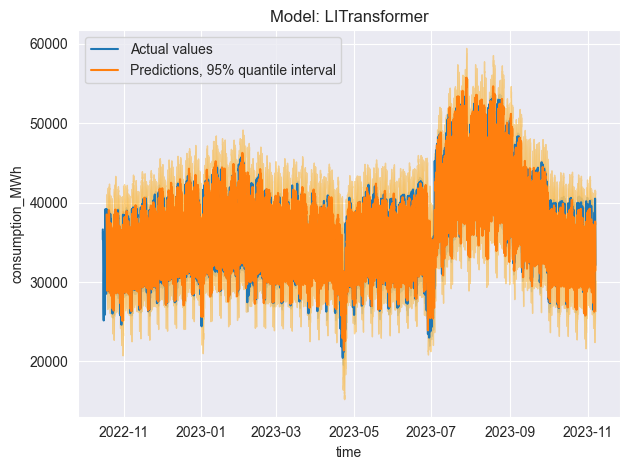

In [61]:
# Predicted vs. actual plot, hourly, entire test period
_ = sns.lineplot(
    data = df_test,
    x = "time",
    y = "consumption_MWh",
    label = "Actual values"
)

_ = sns.lineplot(
    data = df_preds,
    x = "time",
    y = "pred_point",
    label = "Predictions, 95% quantile interval"
)

_ = plt.fill_between(
    x = df_preds.time,
    y1 = df_preds.pred_low,
    y2 = df_preds.pred_high,
    label = "95% prediction interval",
    color = "orange",
    alpha = 0.4
)
_ = plt.title("Model: LITransformer")

In [62]:
def plot_sequence_preds(preds, source_sequences, target_sequences, sequence_index = 0, model = "LITransformer"):

    # Get n. of sequences
    n_sequences = len(target_sequences)
    
    # Get predictions for selected sequence
    preds_low = preds[sequence_index, :, 0]
    preds_point = preds[sequence_index, :, 1]
    preds_high = preds[sequence_index, :, 2]

    # Get & combine actual targets, sources, dates
    date_target = target_sequences[sequence_index].index.to_series()
    target = target_sequences[sequence_index].consumption_MWh.values
    
    date_source = source_sequences[sequence_index].index.to_series()
    source = source_sequences[sequence_index].consumption_lag2.values

    date = pd.concat([date_source, date_target], axis = 0)
    actual = np.concatenate([source, target], axis = 0)

    # Plot
    _ = sns.lineplot(
        x = date,
        y = actual,
        label = "Actual values"
    )

    _ = sns.lineplot(
        x = date_target,
        y = preds_point,
        label = "Predictions, 95% quantile interval"
    )
    
    _ = plt.fill_between(
        x = date_target,
        y1 = preds_low,
        y2 = preds_high,
        color = "orange",
        alpha = 0.4
    )

    _ = plt.title(f"Model: {model},\n Sequence index: {sequence_index} of {n_sequences - 1}")
    _ = plt.xlabel("time")
    _ = plt.ylabel("consumption")

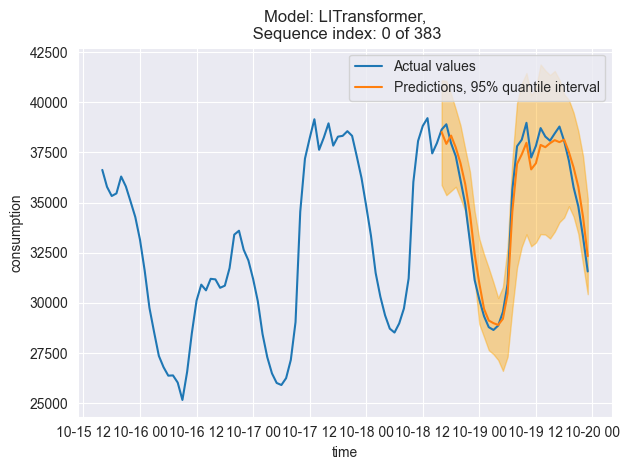

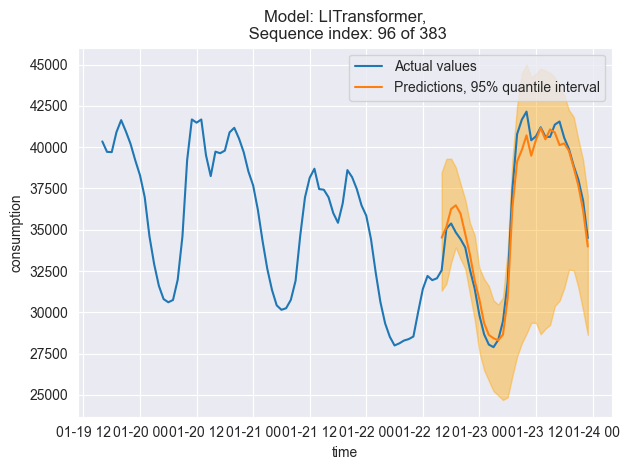

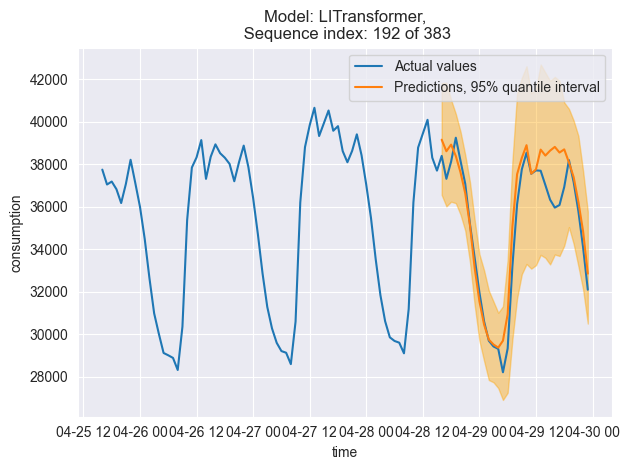

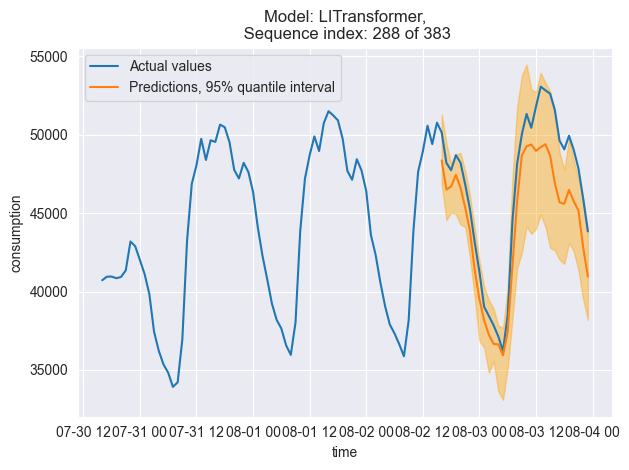

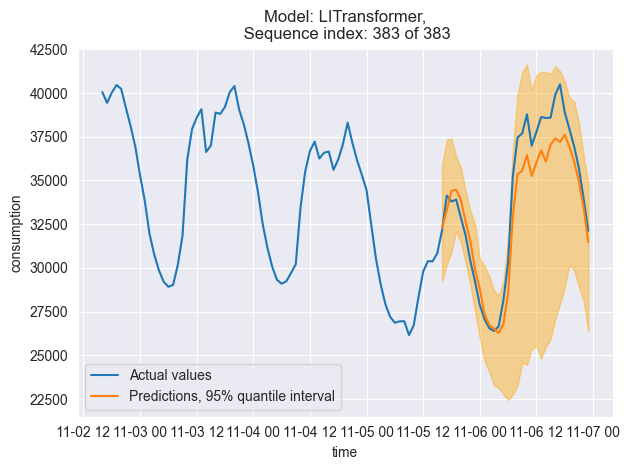

In [63]:
# Predicted vs. actual plots, zoomed in
indices = [i for i in range(0, len(test_target), len(test_target) // 4)]
indices.append(len(test_target) - 1)
for idx in indices:
    plt.figure()
    plot_sequence_preds(preds, test_source, test_target, sequence_index = idx)

In [64]:
# Calculate performance metrics: MAE, RMSLE, MAPE, pinball
rounding = 4
pd.DataFrame([
    mape(df_test_target.consumption_MWh, df_preds.pred_point) * 100,
    rmsle(df_test_target.consumption_MWh, df_preds.pred_point),
    mae(df_test_target.consumption_MWh, df_preds.pred_point),
    pinball(df_test_target.consumption_MWh, df_preds.pred_point, alpha = quantiles[0]),
    pinball(df_test_target.consumption_MWh, df_preds.pred_point, alpha = quantiles[1]),
    pinball(df_test_target.consumption_MWh, df_preds.pred_point, alpha = quantiles[-1])
], columns = ["Model: Inverted quantile Transformer"],
index = [ 
    "MAPE, point", 
    "RMSLE, point",
    "MAE, point",
    f"Pinball loss, q: {quantiles[0] * 100}%",
    f"Pinball loss, q: {quantiles[1] * 100}%",
    f"Pinball loss, q: {quantiles[-1] * 100}%"
]).round(rounding)

,Model: Inverted quantile Transformer
"MAPE, point",3.2748
"RMSLE, point",0.0478
"MAE, point",1188.6721
"Pinball loss, q: 2.5%",699.9720
"Pinball loss, q: 50.0%",594.3360
"Pinball loss, q: 97.5%",488.7000


Keep in mind that for the median quantile, pinball loss equals MAE / 2.